# Script to scan the PSSS photon energy
### Purpose:
To find and centre the PSSS photon energy so the measured spectrum is centred on the camera chip
Contact christopher.arrell@psi.ch

In [1]:
import epics as ep
import numpy as np
import matplotlib.pyplot as plt
from time import sleep
from collections import deque
from scipy.optimize import curve_fit
%matplotlib inline
from IPython.display import clear_output, display

## Setup and functions setup

In [2]:
PSSS_energy_PV_name = 'SARFE10-PSSS059:ENERGY'
PSSS_spectrum_name = 'SARFE10-PSSS059:SPECTRUM_Y'
PSSS_e_axis_name = 'SARFE10-PSSS059:SPECTRUM_X'
PSSS_cam_x_PV_name = 'SARFE10-PSSS059:MOTOR_X5.VAL'
Energy_from_machine_PV_name = 'SARUN03-UIND030:FELPHOTENE'

PSSS_energy_PV = ep.PV(PSSS_energy_PV_name)
PSSS_spectrum_PV = ep.PV(PSSS_spectrum_name)
PSSS_e_axis_PV = ep.PV(PSSS_e_axis_name)
PSSS_cam_x_PV = ep.PV(PSSS_cam_x_PV_name)
Energy_from_machine_PV = ep.PV(Energy_from_machine_PV_name)

PSSS_e_axis = PSSS_e_axis_PV.get()

def set_PSSS_energy(energy):
    PSSS_energy_PV.put(energy, wait=True)
    clear_output(wait=True)
    ! python /ioc/modules/qt/PSSS_motion.py -m1 SARFE10-PSSS059
    sleep(1)
    print(energy)
    
def PSSS_energy_scan(Energy_range, NumShots):
        
    Spectrum_scan = []
            
    for energy in Energy_range:
        set_PSSS_energy(energy)  
           
        Spectrum_this_energy = deque(maxlen = NumShots)
        def on_value_change(value=None,pv = None, **kwargs):
            Spectrum_this_energy.append(value)

            if len(Spectrum_this_energy) == NumShots:
                pv.clear_callbacks()
                
        PSSS_spectrum_PV.add_callback(callback=on_value_change, pv =PSSS_spectrum_PV)
        while len(Spectrum_this_energy) < NumShots:
            sleep(1)
        Spectrum_scan.append(np.array(Spectrum_this_energy))
        
    return(np.array(Spectrum_scan))



## User inputs - define energy range to scan below by running the appropiate cell
Below is for a large scan range assuming offset from machine upto $\pm$ 300 eV

In [19]:
offset_from_machine = 300
E_from = Energy_from_machine_PV.get()*1e3-offset_from_machine
E_to = Energy_from_machine_PV.get()*1e3+offset_from_machine
steps = 60
NumShots= 100
Energy_range = np.linspace(E_from, E_to, steps)

Below is for a large scan range assuming offset from machine upto $\pm$ 100 eV

In [21]:
offset_from_machine = 100
E_from = Energy_from_machine_PV.get()*1e3-offset_from_machine
E_to = Energy_from_machine_PV.get()*1e3+offset_from_machine
steps = 60
NumShots= 100
Energy_range = np.linspace(E_from, E_to, steps)

Manual scan range

In [22]:
offset_from_machine = 300
E_from = 9900
E_to = 10150
steps = 60
NumShots= 100
Energy_range = np.linspace(E_from, E_to, steps)

## Scan and take data

In [23]:
Scan_spec = PSSS_energy_scan(Energy_range,NumShots)

energy2motor: camArmRot: 36.8206 cristBendRot: 19.4771 camPosX:-18.4472 evPerPix:0.03361
PSSS_motion done.
10150.0


## Plot and return energy

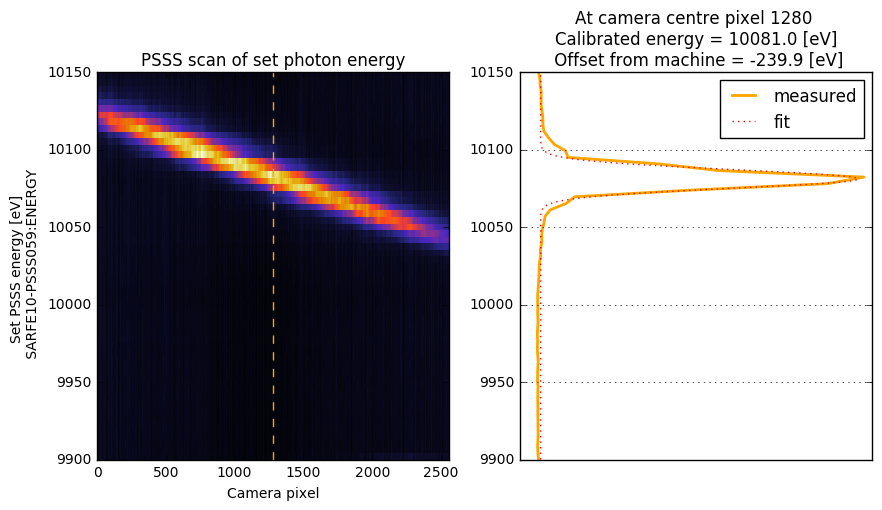

In [28]:
Energy_range_fit = np.linspace(Energy_range[0], Energy_range[-1], len(Energy_range)*10)
centre_line_out = Scan_spec[:,:,int(Scan_spec.shape[2]/2)].mean(axis=1)
try:
    popt,pcov = curve_fit(gaus,Energy_range,centre_line_out,p0=[1,Energy_range[np.argmax(centre_line_out)],Energy_range.mean()*1e-3,1e3*NumShots])
except:
    print('Fit failed: spectrum might not be near scan range center')
    popt = [0.0, 0.0, 0.0, 0.0]
measured_offset = Energy_from_machine_PV.get()*1e3 - popt[1]
plt.figure(figsize=[10,5])
plt.subplot(121)
plt.title('PSSS scan of set photon energy')
plt.pcolormesh(np.arange(0,Scan_spec.shape[2]), Energy_range, Scan_spec.mean(axis=1),cmap='CMRmap')
plt.vlines(int(Scan_spec.shape[2]/2), Energy_range[0], Energy_range[-1],linestyles='--', colors='orange')
plt.xlim([0,Scan_spec.shape[2]])
plt.xlabel('Camera pixel')
plt.ylabel('Set PSSS energy [eV] \n SARFE10-PSSS059:ENERGY')

plt.subplot(122)
plt.title('At camera centre pixel %1i \nCalibrated energy = %.1f [eV]\n Offset from machine = %.1f [eV]'%(int(Scan_spec.shape[2]/2),popt[1],measured_offset))
plt.plot(centre_line_out,Energy_range,linewidth = 2, color = 'orange',label ='measured')
plt.plot(gaus(Energy_range_fit,*popt),Energy_range_fit,'r:',label='fit')
plt.xticks([])
plt.legend()
plt.grid(True)


## Set fitted energy
Cell below will push the fitted energy to the PSSS

In [29]:
set_PSSS_energy(popt[1])

energy2motor: camArmRot: 37.0835 cristBendRot: 19.6071 camPosX:-18.5924 evPerPix:0.0331261
PSSS_motion done.
10081.021012
